Dummy variables:
- 1 = original implementation
- 0 = new implementation

Dummy variable indexes:
- first position: uniform
- second position: L2 or rand
- third position: use of Project Output bias

In [1]:
import os
import math
import shutil
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import scipy
from scipy.stats import mannwhitneyu, pearsonr
from statsmodels.stats.multitest import multipletests

import itertools

import torch

import matplotlib.pyplot as plt
from plotnine import ggplot, aes, geom_line, theme_bw, theme, geom_point, geom_hline, annotate, scale_y_log10
import plotnine as p9
import seaborn as sns
import gc

In [2]:
sclembas_path = os.path.join(os.path.abspath('../../LEMBAS'))

import sys
sys.path.insert(1, sclembas_path)

from LEMBAS.model.bionetwork import format_network, SignalingModel
from LEMBAS.benchmarking_version.benchmark_train import train_signaling_model
import LEMBAS.utilities as utils
from LEMBAS import plotting, io

In [3]:
n_cores = 12
utils.set_cores(n_cores)

seed = 888
if seed:
    torch.use_deterministic_algorithms(True)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
    utils.set_seeds(seed = seed)
    
device = 'cuda' if torch.cuda.is_available() else 'cpu'

data_path = '/nobackup/users/hmbaghda/LEMBAS_benchmark/'

Load and format the data:

In [11]:
def inverse_sigmoid(y):
    return np.log(y / (1 - y))

In [12]:
net = pd.read_csv('https://zenodo.org/records/10815391/files/macrophage_network.tsv', sep = '\t', index_col = False)
ligand_input = pd.read_csv('https://zenodo.org/records/10815391/files/macrophage_ligands.tsv', sep = '\t', index_col = 0)
tf_output = pd.read_csv('https://zenodo.org/records/10815391/files/macrophage_TFs.tsv', sep='\t', low_memory=False, index_col=0)

untransformed_tf_output = inverse_sigmoid(tf_output)


In [13]:
stimulation_label = 'stimulation'
inhibition_label = 'inhibition'
weight_label = 'mode_of_action'
source_label = 'source'
target_label = 'target'
# Format network
net = format_network(net, weight_label = weight_label, stimulation_label = stimulation_label, inhibition_label = inhibition_label)



In [14]:
nodes = net[[source_label, target_label]].values.flatten()
tf_output = tf_output[[col for col in tf_output.columns if col in nodes]]
untransformed_tf_output = untransformed_tf_output[tf_output.columns]


Set up the model parameters:

In [15]:
projection_amplitude_in = 3
projection_amplitude_out = 1.2
# other parameters
bionet_params = {'target_steps': 100, 'max_steps': 150, 'exp_factor':50, 'tolerance': 1e-5, 'leak':1e-2} # fed directly to model

# training parameters
lr_params = {'max_iter': 5000, 
            'learning_rate': 2e-3}
other_params = {'batch_size': 10, 'noise_level': 10, 'gradient_noise_level': 1e-9}
regularization_params = {'param_lambda_L2': 1e-6, 'moa_lambda_L1': 0.1, 'ligand_lambda_L2': 1e-5, 'uniform_lambda_L2': 1e-4, 
                'uniform_max': 1/projection_amplitude_out, 'spectral_loss_factor': 1e-5}
spectral_radius_params = {'n_probes_spectral': 5, 'power_steps_spectral': 5, 'subset_n_spectral': 5}
target_spectral_radius = 0.8
hyper_params = {**lr_params, **other_params, **regularization_params, **spectral_radius_params} # fed into training function



Set up training parameters:

In [11]:
# def models_are_allclose(model1, model2, rtol=1e-05, atol=1e-08):
#     for param1, param2 in zip(model1.parameters(), model2.parameters()):
#         if not np.allclose(param1.detach().cpu().numpy(), param2.detach().cpu().numpy(), rtol=rtol, atol=atol):
#             return False
#     return True


# # Check if the parameters are close (they should be identical here)
# models_are_allclose(mod_no_bias, mod_bias)



In [16]:
iter_keys = ['uniform', 'L2_or_rand', 'ProjectOutput_bias']
iter_dicts = [dict(zip(iter_keys, values)) for values in itertools.product([0, 1], repeat=len(iter_keys))]

# only interested in hte bias comparison for the original implementation
for iter_dict in iter_dicts:
    if iter_dict['ProjectOutput_bias'] == 0:
        if iter_dict['uniform'] == 0 or iter_dict['L2_or_rand'] == 0:
            iter_dicts.remove(iter_dict)

# new bias first to determine param_lambda_L2
iter_dicts = [k for k in iter_dicts if k['ProjectOutput_bias'] == 0] + [k for k in iter_dicts if k['ProjectOutput_bias'] == 1]             

bias_map = {0: untransformed_tf_output.copy(), # new implementation can handle negatives
            1: tf_output.copy()}
dict_to_bench_default = {'test_time': 0}


Find a CV split where there is no "zero-shot" learning (all individual ligands have been seen before):

LOO, but skip zero-shot learning ones:

In [13]:
k_folds = {}
samples = ligand_input.index.tolist()

zero_shot_samples = []

k = 0
for sample in samples:
    samples_ = samples.copy()
    samples_.remove(sample)
    
    X_train = ligand_input.loc[samples_, :]
    
    X_test = pd.DataFrame(ligand_input.loc[sample, :]).T
    y_test = pd.DataFrame(tf_output.loc[sample, :]).T    
    
    test_ligands = X_test.columns[(X_test != 0).any()]
    train_ligands = X_train.columns[(X_train != 0).any()]

    if len(set(test_ligands).difference(train_ligands)) != 0: # zero-shot
        zero_shot_samples.append(sample)
    else: 
        k_folds[k] = {'train': samples_, 
                     'test': sample}
        k += 1

In [14]:
zero_shot_samples

['GC', 'IL10', 'IL13']

Train and test the model:

In [15]:
def _train_model(mod, dict_to_bench, hyper_params, fn = None):
#     mod.X_in = mod.df_to_tensor(mod.X_in)
#     mod.y_out = mod.df_to_tensor(mod.y_out)

    
    mod.input_layer.weights.requires_grad = False # don't learn scaling factors for the ligand input concentrations
    mod.signaling_network.prescale_weights(target_radius = target_spectral_radius) # spectral radius

    # loss and optimizer
    loss_fn = torch.nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam

    #
    res = train_signaling_model(mod, 
                                optimizer, 
                                loss_fn, 
                                reset_epoch = 200, 
                                hyper_params = hyper_params, 
                                train_seed = seed, 
                                verbose = False,
                                dict_to_bench=dict_to_bench, 
                               train_split_frac = {'train': 1, 'test': None, 'validation': None})

    mod, cur_loss, cur_eig, mean_loss, stats, _, _, _, _, _, _ = res
    if fn is not None:
#         torch.save(mod.state_dict(), fn)
        io.write_pickled_object(mod, fn)
        gradients = {name: param.grad for name, param in mod.named_parameters()}
        fn_grad = fn.replace('.pickle', '_gradients.pickle')
        io.write_pickled_object(gradients, fn_grad)
    return mod #, stats_df

def pearson_corr(tensor1, tensor2, axis=0):
    "Row- (axis = 0) or column- (axis=1) wise pearson correlation between two torch tensors."
    if axis == 1:
        tensor1 = tensor1.t()
        tensor2 = tensor2.t()
        
    mean1 = torch.mean(tensor1, dim=1, keepdim=True)
    mean2 = torch.mean(tensor2, dim=1, keepdim=True)

    tensor1_centered = tensor1 - mean1
    tensor2_centered = tensor2 - mean2
    covariance = torch.sum(tensor1_centered * tensor2_centered, dim=1)
    std1 = torch.sqrt(torch.sum(tensor1_centered ** 2, dim=1))
    std2 = torch.sqrt(torch.sum(tensor2_centered ** 2, dim=1))
    
    correlation = covariance / (std1 * std2)
    
    return correlation


def _evaluate_model(mod, X_test, y_test):
    X_test = mod.df_to_tensor(X_test)
    if len(X_test.shape) == 1: # 1 sample
        X_test = X_test.reshape(1,-1)

    tf_order = {k: v for k, v in mod.node_idx_map.items() if k in tf_output.columns}
    y_test = mod.df_to_tensor(y_test[sorted(tf_order, key=tf_order.get)])
    y_test = y_test.reshape(1,-1)

    mod.eval()
    with torch.inference_mode():
        Y_hat, _ = mod(X_test)
        loss_fn = torch.nn.MSELoss(reduction='mean')
        mse_loss = loss_fn(Y_hat, y_test).detach().cpu().numpy().item()
        corr_row = torch.nanmean(pearson_corr(Y_hat, y_test, axis=0)).cpu().numpy().item()

    return mse_loss, corr_row, Y_hat

In [14]:
if os.path.isfile(os.path.join(data_path, 'processed', 'benchmark_cv.csv')):
    _ = shutil.copyfile(os.path.join(data_path, 'processed', 'benchmark_cv.csv'), 
                        os.path.join(data_path, 'processed', 'backup_benchmark_cv.csv'))

    
    
    k_folds_res = pd.read_csv(os.path.join(data_path, 'processed', 'benchmark_cv.csv'), index_col = 0)
    curr_k = k_folds_res.k.max()
    k_run = k_folds_res[k_folds_res.k ==  curr_k]
    if k_run.shape[0] == len(iter_dicts): # gone through all the k's
        curr_k += 1

    k_folds_res['param_lambda_L2'] = k_folds_res['param_lambda_L2'].apply(lambda x: '{:.0e}'.format(x))
else:
    k_folds_res = pd.DataFrame(columns = ['k', 'mse', 'samples_pearson'] + iter_keys + ['param_lambda_L2'])
    curr_k = 0

if os.path.isfile(os.path.join(data_path, 'processed', 'benchmark_consistency.csv')):
    _ = shutil.copyfile(os.path.join(data_path, 'processed', 'benchmark_consistency.csv'), 
                        os.path.join(data_path, 'processed', 'backup_benchmark_consistency.csv'))
    
    
    mod_consistency = pd.read_csv(os.path.join(data_path, 'processed', 'benchmark_consistency.csv'), index_col = 0)
else:
    mod_consistency = pd.DataFrame(columns = ['k', 'condition_1', 'condition_2', 'prediction',
                                          'signaling_weights', 
                                          'signaling_bias',
                                          'output_layer_weights', 
                                          'signaling_weights_grad', 
                                          'signaling_bias_grad',
                                          'output_layer_weights_grad'])
    
min_lambda = 1e-9

In [31]:
# for fn in [os.path.join(data_path, 'processed', 'benchmark_consistency.csv'), 
#           os.path.join(data_path, 'processed', 'benchmark_cv.csv')]:
#     print('rm ' + fn)
# print('')

rm /nobackup/users/hmbaghda/LEMBAS_benchmark/processed/benchmark_consistency.csv
rm /nobackup/users/hmbaghda/LEMBAS_benchmark/processed/benchmark_cv.csv



In [21]:
for k in k_folds:
    if k >= curr_k:
        hyper_params_k = hyper_params.copy()
        print(k)
        try:
            print('A')
            for iter_dict in iter_dicts:
                iter_name = '-'.join(['^'.join([k,str(v)]) for k,v in iter_dict.items()])
                k_run = k_folds_res[(k_folds_res.k ==  k)]# & (k_folds_res.param_lambda_L2 == '{:.0e}'.format(hyper_params_k['param_lambda_L2']))]
                if k_run.shape[0] != 0:
                    hyper_params_k['param_lambda_L2'] = float(k_run.iloc[0,:]['param_lambda_L2'])
                    k_run = k_folds_res[(k_folds_res.k ==  k) & (k_folds_res.param_lambda_L2 == '{:.0e}'.format(hyper_params_k['param_lambda_L2']))]
                    iters_run = k_run[iter_keys].apply(lambda x: '-'.join(['^'.join([k,str(int(v))]) for k,v in dict(zip(iter_keys, x.values)).items()]), 
                                                       axis = 1).tolist()
                    if len(iters_run) == len(iter_dicts):
                        iters_run = []
                        hyper_params_k['param_lambda_L2'] /= 10
                else:
                    iters_run = []

                if iter_name not in iters_run:
                    print('A: ' + iter_name)
                    po_bias = iter_dict['ProjectOutput_bias']
                    tf_output = bias_map[po_bias]

                    mod = SignalingModel(net = net,
                                         X_in = ligand_input.loc[k_folds[k]['train'], :],
                                         y_out = tf_output.loc[k_folds[k]['train'], :],
                                         projection_amplitude_in = projection_amplitude_in, 
                                         projection_amplitude_out = projection_amplitude_out,
                                         weight_label = weight_label, source_label = source_label, target_label = target_label,
                                         bionet_params = bionet_params,
                                         dtype = torch.float32, device = device, seed = seed)

                    dict_to_bench = {**dict_to_bench_default, **iter_dict}
                    dict_to_bench['name'] = iter_name
    #                 fn = None if po_bias else os.path.join(data_path, 'processed', dict_to_bench['name'] + '.pickle')
                    fn = os.path.join(data_path, 'processed', dict_to_bench['name'] + '.pickle')
                    mod = _train_model(mod = mod, 
                                       dict_to_bench=dict_to_bench,
                                       hyper_params = hyper_params_k,
                                       fn = fn)
                    mse_loss, corr, Y_hat = _evaluate_model(mod = mod, 
                                                 X_test = ligand_input.loc[k_folds[k]['test'], :], 
                                                 y_test = tf_output.loc[k_folds[k]['test'], :])
                    np.savetxt(os.path.join(data_path, 'interim', dict_to_bench['name'] + '_Yhat.csv'),
                               Y_hat.detach().cpu().numpy(), delimiter=",")
                    k_folds_res.loc['k^' +str(k) + '-' + iter_name, :] = [k, mse_loss, corr] + [iter_dict[k] for k in iter_keys] + ['{:.0e}'.format(hyper_params_k['param_lambda_L2'])]
                    k_folds_res.to_csv(os.path.join(data_path, 'processed', 'benchmark_cv.csv'))
                    del mod, Y_hat
                    torch.cuda.empty_cache()
                    gc.collect()
#                     torch.cuda.ipc_collect()
                    
                    err = False
        except:
            print('B')
            err = True
            while err and hyper_params_k['param_lambda_L2'] >= min_lambda:
                try:
                    hyper_params_k['param_lambda_L2']/=10
                    for iter_dict in iter_dicts:
                        iter_name = '-'.join(['^'.join([k,str(v)]) for k,v in iter_dict.items()])
                        k_run = k_folds_res[(k_folds_res.k ==  k) & (k_folds_res.param_lambda_L2 == '{:.0e}'.format(hyper_params_k['param_lambda_L2']))]
                        if k_run.shape[0] != 0:
                            iters_run = k_run[iter_keys].apply(lambda x: '-'.join(['^'.join([k,str(int(v))]) for k,v in dict(zip(iter_keys, x.values)).items()]), 
                                                               axis = 1).tolist()
                        else:
                            iters_run = []

                        if iter_name not in iters_run:
                            print('B: ' + iter_name + '---' + '{:.0e}'.format(hyper_params_k['param_lambda_L2']))
                            po_bias = iter_dict['ProjectOutput_bias']
                            tf_output = bias_map[po_bias]

                            mod = SignalingModel(net = net,
                                                 X_in = ligand_input.loc[k_folds[k]['train'], :],
                                                 y_out = tf_output.loc[k_folds[k]['train'], :],
                                                 projection_amplitude_in = projection_amplitude_in, 
                                                 projection_amplitude_out = projection_amplitude_out,
                                                 weight_label = weight_label, source_label = source_label, target_label = target_label,
                                                 bionet_params = bionet_params,
                                                 dtype = torch.float32, device = device, seed = seed)

                            dict_to_bench = {**dict_to_bench_default, **iter_dict}
                            dict_to_bench['name'] = iter_name
            #                 fn = None if po_bias else os.path.join(data_path, 'processed', dict_to_bench['name'] + '.pickle')
                            fn = os.path.join(data_path, 'processed', dict_to_bench['name'] + '.pickle')
                            mod = _train_model(mod = mod, 
                                               dict_to_bench=dict_to_bench,
                                               hyper_params = hyper_params_k,
                                               fn = fn)
                            mse_loss, corr, Y_hat = _evaluate_model(mod = mod, 
                                                         X_test = ligand_input.loc[k_folds[k]['test'], :], 
                                                         y_test = tf_output.loc[k_folds[k]['test'], :])
                            np.savetxt(os.path.join(data_path, 'interim', dict_to_bench['name'] + '_Yhat.csv'),
                                       Y_hat.detach().cpu().numpy(), delimiter=",")
                            k_folds_res.loc['k^' +str(k) + '-' + iter_name, :] = [k, mse_loss, corr] + [iter_dict[k] for k in iter_keys] + ['{:.0e}'.format(hyper_params_k['param_lambda_L2'])]
                            k_folds_res.to_csv(os.path.join(data_path, 'processed', 'benchmark_cv.csv'))

                            del mod, Y_hat
                            torch.cuda.empty_cache()
                            gc.collect()
#                             torch.cuda.ipc_collect()

                    err = False
                except:
                    pass
        if err:
            print('C: ' + str(k))
            for iter_dict in iter_dicts:
                iter_name = '-'.join(['^'.join([k,str(v)]) for k,v in iter_dict.items()])
                k_folds_res.loc['k^' +str(k) + '-' + iter_name, :] = [k, np.nan, np.nan] + [iter_dict[k] for k in iter_keys] + [np.nan]
                k_folds_res.to_csv(os.path.join(data_path, 'processed', 'benchmark_cv.csv'))
#                 if not po_bias:
#                     mod_list[dict_to_bench['name']] = mod


        # do the comparisons here
        if not k_folds_res[k_folds_res.k ==  k]['param_lambda_L2'].isna().any():
            k_run = k_folds_res[k_folds_res.k ==  k]
            if k_run.shape[0] != len(iter_dicts):
                raise ValueError('Havent loaded the current, completed k')
            mod_list = k_run[iter_keys].apply(lambda x: '-'.join(['^'.join([k,str(int(v))]) for k,v in dict(zip(iter_keys, x.values)).items()]), 
                                           axis = 1).tolist()
            mod_list = {ml: io.read_pickled_object(os.path.join(data_path, 'processed', ml+ '.pickle')) for ml in mod_list}# if ml[-1] != '1'}
            for ml, mod in mod_list.items():
                fn_grad = os.path.join(data_path, 'processed', ml + '_gradients.pickle')
                mod_gradients = io.read_pickled_object(fn_grad)
                for name, param in mod.named_parameters():
                    param.grad = mod_gradients[name]

            Y_hats = {fn: np.genfromtxt(os.path.join(data_path, 'interim', fn + '_Yhat.csv')
                                , delimiter=",", skip_header=0) for fn in mod_list}


            for pc in itertools.combinations(mod_list, 2):
                y_hats_corr = pearson_corr(torch.tensor(Y_hats[pc[0]]).reshape(-1,1), torch.tensor(Y_hats[pc[1]]).reshape(-1,1), 
                                        axis = 1).item()

                mod_0 = mod_list[pc[0]]
                mod_1 = mod_list[pc[1]]

                signaling_weights_corr = pearson_corr(mod_0.signaling_network.weights.detach().flatten().reshape(-1,1), 
                                                      mod_1.signaling_network.weights.detach().flatten().reshape(-1,1), 
                                                      axis = 1).item()
                signaling_weights_grad_corr = pearson_corr(mod_0.signaling_network.weights.grad.detach().flatten().reshape(-1,1), 
                                          mod_1.signaling_network.weights.grad.detach().flatten().reshape(-1,1), 
                                          axis = 1).item()





                signaling_bias_corr = pearson_corr(mod_0.signaling_network.bias.detach().flatten().reshape(-1,1), 
                                                   mod_1.signaling_network.bias.detach().flatten().reshape(-1,1), 
                                                   axis = 1).item()
                signaling_bias_grad_corr = pearson_corr(mod_0.signaling_network.bias.grad.detach().flatten().reshape(-1,1), 
                                                   mod_1.signaling_network.bias.grad.detach().flatten().reshape(-1,1), 
                                                   axis = 1).item()

                ol_weights_corr = pearson_corr(mod_0.output_layer.weights.detach().flatten().reshape(-1,1), 
                                               mod_1.output_layer.weights.detach().flatten().reshape(-1,1), 
                                               axis = 1).item()
                ol_weights_grad_corr = pearson_corr(mod_0.output_layer.weights.grad.detach().flatten().reshape(-1,1), 
                                   mod_1.output_layer.weights.grad.detach().flatten().reshape(-1,1), 
                                   axis = 1).item()

                mod_consistency.loc[mod_consistency.shape[0]] = [k, pc[0], pc[1], 
                                                                y_hats_corr, 
                                                                signaling_weights_corr, 
                                                                signaling_bias_corr, 
                                                                ol_weights_corr,
                                                                signaling_weights_grad_corr, 
                                                                signaling_bias_grad_corr, 
                                                                ol_weights_grad_corr]
            mod_consistency.to_csv(os.path.join(data_path, 'processed', 'benchmark_consistency.csv'))

            del mod_list, Y_hats, mod_0, mod_1
            torch.cuda.empty_cache()
#             torch.cuda.ipc_collect()
            gc.collect()

    

Visualize and quantify the results:

In [20]:
k_folds_res = pd.read_csv(os.path.join(data_path, 'processed', 'benchmark_cv.csv'), index_col = 0)

# combs = pd.DataFrame(columns = ['uniform', 'L2_or_rand', 'bias'], 
#             data = [[int(i[-1]) for i in x.split('-')[1:]] for x in k_folds_res.index])
# k_folds_res.reset_index(drop = True, inplace = True)
# k_folds_res = pd.concat([k_folds_res, combs], axis = 1)
k_folds_res['cond'] = k_folds_res[['uniform', 'L2_or_rand', 'ProjectOutput_bias']].astype(int).astype(str).agg('^'.join, axis=1).tolist()
k_folds_res['cond'] = pd.Categorical(k_folds_res['cond'], 
                                     categories=['1^1^1', '0^1^1', '1^0^1', '1^1^0', '0^0^1'], 
                                     ordered=True)


In [21]:
def cohen_d(vector_1, vector_2):
    # Calculate the means of the two vectors
    mean1 = np.mean(vector_1)
    mean2 = np.mean(vector_2)

    # Calculate the standard deviations of the two vectors
    std1 = np.std(vector_1, ddof=1)
    std2 = np.std(vector_2, ddof=1)

    # Calculate the pooled standard deviation
    n1 = len(vector_1)
    n2 = len(vector_2)
    pooled_std = np.sqrt(((n1 - 1) * std1**2 + (n2 - 1) * std2**2) / (n1 + n2 - 2))

    return (mean1 - mean2) / pooled_std

''

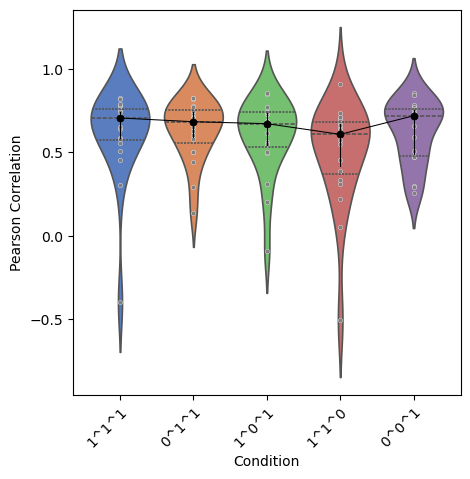

In [22]:
fig, ax = plt.subplots(ncols = 1, figsize = (5,5))

# sns.set(style="white", context="talk", font_scale = 0.8)
sns.violinplot(data = k_folds_res, x = 'cond', y = 'samples_pearson', ax = ax, 
              palette='muted', inner='quartile', linewidth=1.2, zorder = 1)
sns.pointplot(data=k_folds_res, x="cond", y="samples_pearson", 
              estimator="median", color="black", 
              errorbar=('ci', 95), n_boot=1000, seed=seed,
              ax=ax,
              markers="o", markersize=5, linewidth=0.75)#, zorder = 3)
sns.scatterplot(data=k_folds_res, x="cond", y="samples_pearson", 
                color="gray", ax=ax, s = 10)#, zorder = 2)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
ax.xaxis.set_tick_params(which='both', bottom=True, top=False, direction='out')
ax.yaxis.set_tick_params(which='major', left=True, right=False, direction='out')
ax.set_ylabel('Pearson Correlation')
ax.set_xlabel('Condition')

# get statistics
comparisons = list(itertools.combinations(k_folds_res.cond.unique(), 2))
pvals = []
effect_size = []
for comp in comparisons:
    comp_0 = k_folds_res[k_folds_res.cond == comp[0]]['samples_pearson']
    comp_1 = k_folds_res[k_folds_res.cond == comp[1]]['samples_pearson']
    _, pval = scipy.stats.mannwhitneyu(comp_0, comp_1, alternative = 'less')
    pvals.append(pval)

    effect_size.append(cohen_d(comp_0, comp_1))

_, fdr, _, _ = multipletests(pvals, method='fdr_bh')

x_pos_dict = dict(zip([tick.get_text() for tick in ax.get_xticklabels()], 
                      [tick.get_position()[0] for tick in ax.get_xticklabels()]))
annotation_y_offset = 0.7
max_y = k_folds_res.samples_pearson.max() + 0.5
idx_counter = 0
for idx, ((group1, group2), p_value, effect) in enumerate(zip(comparisons, fdr, effect_size)):

    significance = "N.S."
    if p_value <= 1e-4:
        significance = "****"
    elif p_value <= 0.001:
        significance = "***"
    elif p_value <= 0.01:
        significance = "**"
    elif p_value <= 0.1:
        significance = "*"
    if significance != "N.S.":
        x1 = x_pos_dict[group1]
        x2 = x_pos_dict[group2]
        x_mid = (x1 + x2) / 2

        y_pos = max_y + (idx_counter * annotation_y_offset)
        ax.plot([x1, x2], [y_pos, y_pos], color='black', lw=1.5)
        annotation_text = "Cohen's D: {:.2f}, ".format(effect) + significance #'Cohen'f"Cohen's d={effect:.2f}"
        ax.text(x_mid, y_pos + 0.15, annotation_text, ha='center', color='black', fontsize=10)
        idx_counter += 1

;

In [61]:
mod_consistency = pd.read_csv(os.path.join(data_path, 'processed', 'benchmark_consistency.csv'), index_col = 0)

cond_cols= ['condition_1', 'condition_2']
for col in cond_cols:
    mod_consistency[col] = mod_consistency[col].apply(lambda x: '^'.join([i.split('^')[1] for i in x.split('-')]))
    
    
comb_order = ['0^1^1-1^1^1', '1^0^1-1^1^1', '0^0^1-1^1^1', 
    '0^1^1-1^0^1',
    '0^0^1-0^1^1', '0^0^1-1^0^1', 
    '1^1^0-1^1^1',
    '1^1^0-0^1^1', '1^1^0-1^0^1',
    '1^1^0-0^0^1']
mod_consistency['combs'] = pd.Categorical(mod_consistency['condition_1'] + '-' + mod_consistency['condition_2'], 
                                         categories = comb_order, 
                                         ordered = True) 
mod_consistency.sort_values(by = 'combs', inplace = True)

In [62]:
def clustermap_format(viz_df):
    h_df = viz_df.groupby(cond_cols).mean().reset_index()
    conditions = pd.unique(h_df[['condition_1', 'condition_2']].values.ravel('K'))
    pairwise_dict = {(row['condition_1'], row['condition_2']): row[viz_col] for _, row in h_df.iterrows()}
    for (cond1, cond2), value in pairwise_dict.copy().items():
        pairwise_dict[(cond2, cond1)] = value
    for condition in conditions:
        pairwise_dict[(condition, condition)] = 1
    h_df = pd.DataFrame(
        [(cond1, cond2, value) for (cond1, cond2), value in pairwise_dict.items()],
        columns=['condition_1', 'condition_2', viz_col]
    )
    h_df = h_df.sort_values(by=['condition_1', 'condition_2']).reset_index(drop=True)
    h_df = h_df.pivot(index = cond_cols[0], columns = cond_cols[1], values=viz_col)
    return h_df

In [65]:
viz_cols = list(set(mod_consistency.columns).difference(['k', 'combs'] + cond_cols))
h_dfs, viz_dfs = {}, {}
for viz_col in viz_cols:
    viz_df = mod_consistency[cond_cols + [viz_col]]
    h_df = clustermap_format(viz_df)
    viz_df['comparison'] = viz_df[cond_cols].agg('-'.join, axis=1).tolist()
    h_dfs[viz_col] = h_df
    viz_dfs[viz_col] = viz_df
    


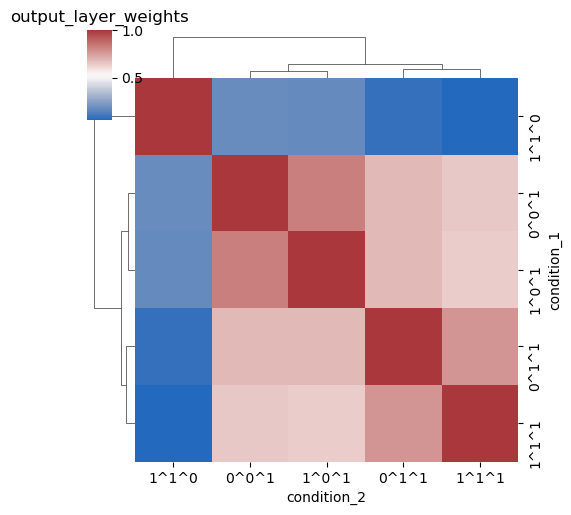

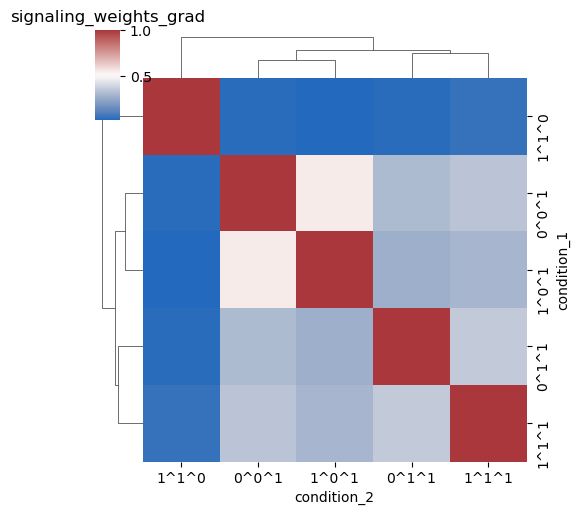

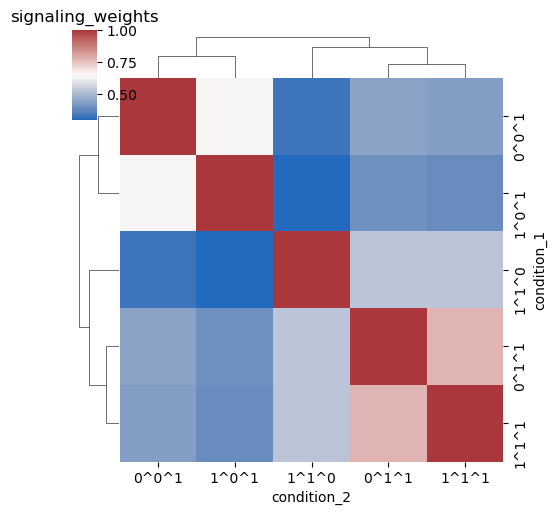

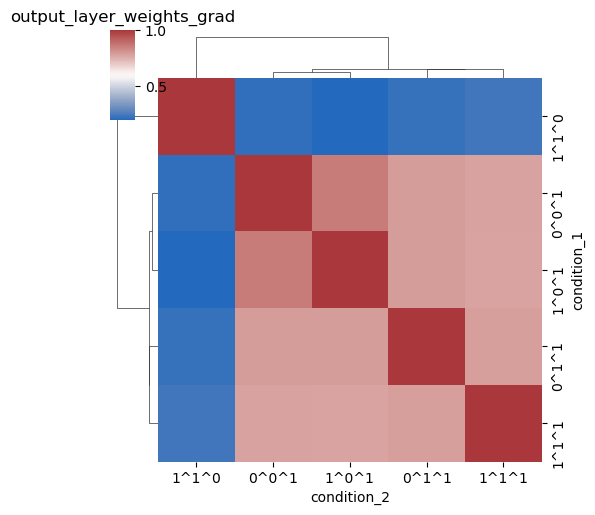

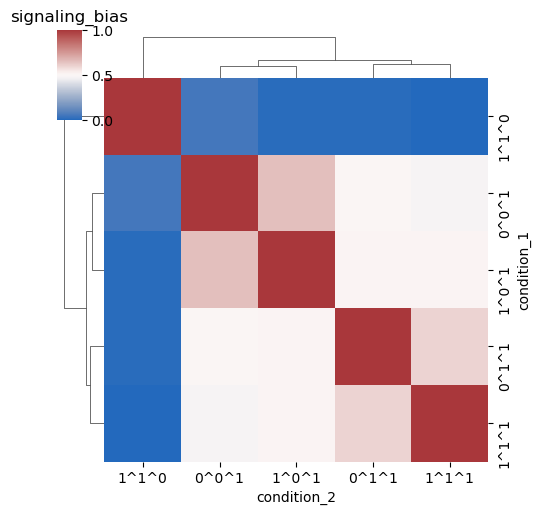

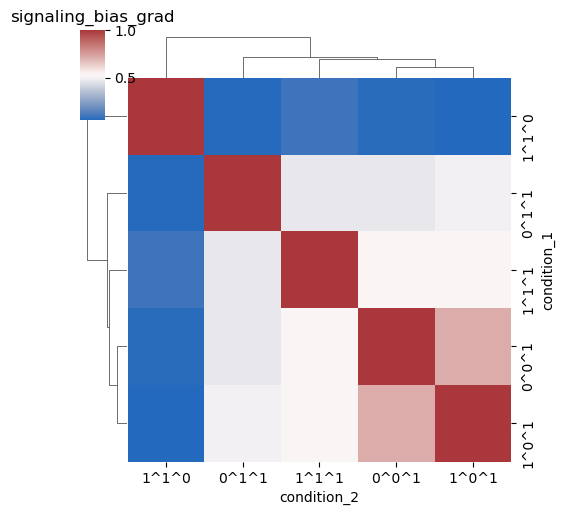

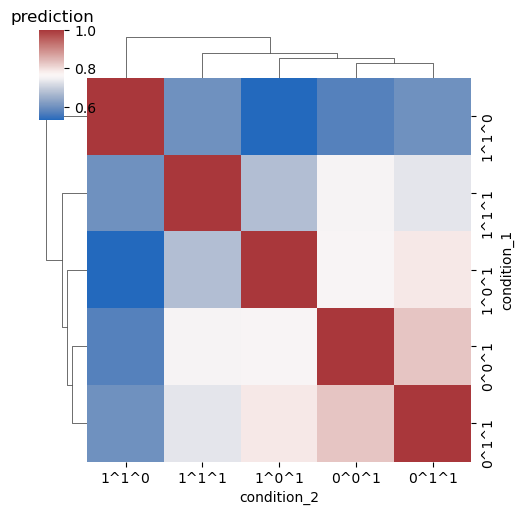

In [66]:
for viz_col, h_df in h_dfs.items():
    sns.clustermap(h_df, figsize=(5,5), cmap = "vlag", dendrogram_ratio=(0.1, 0.1))
    plt.title(viz_col)

''

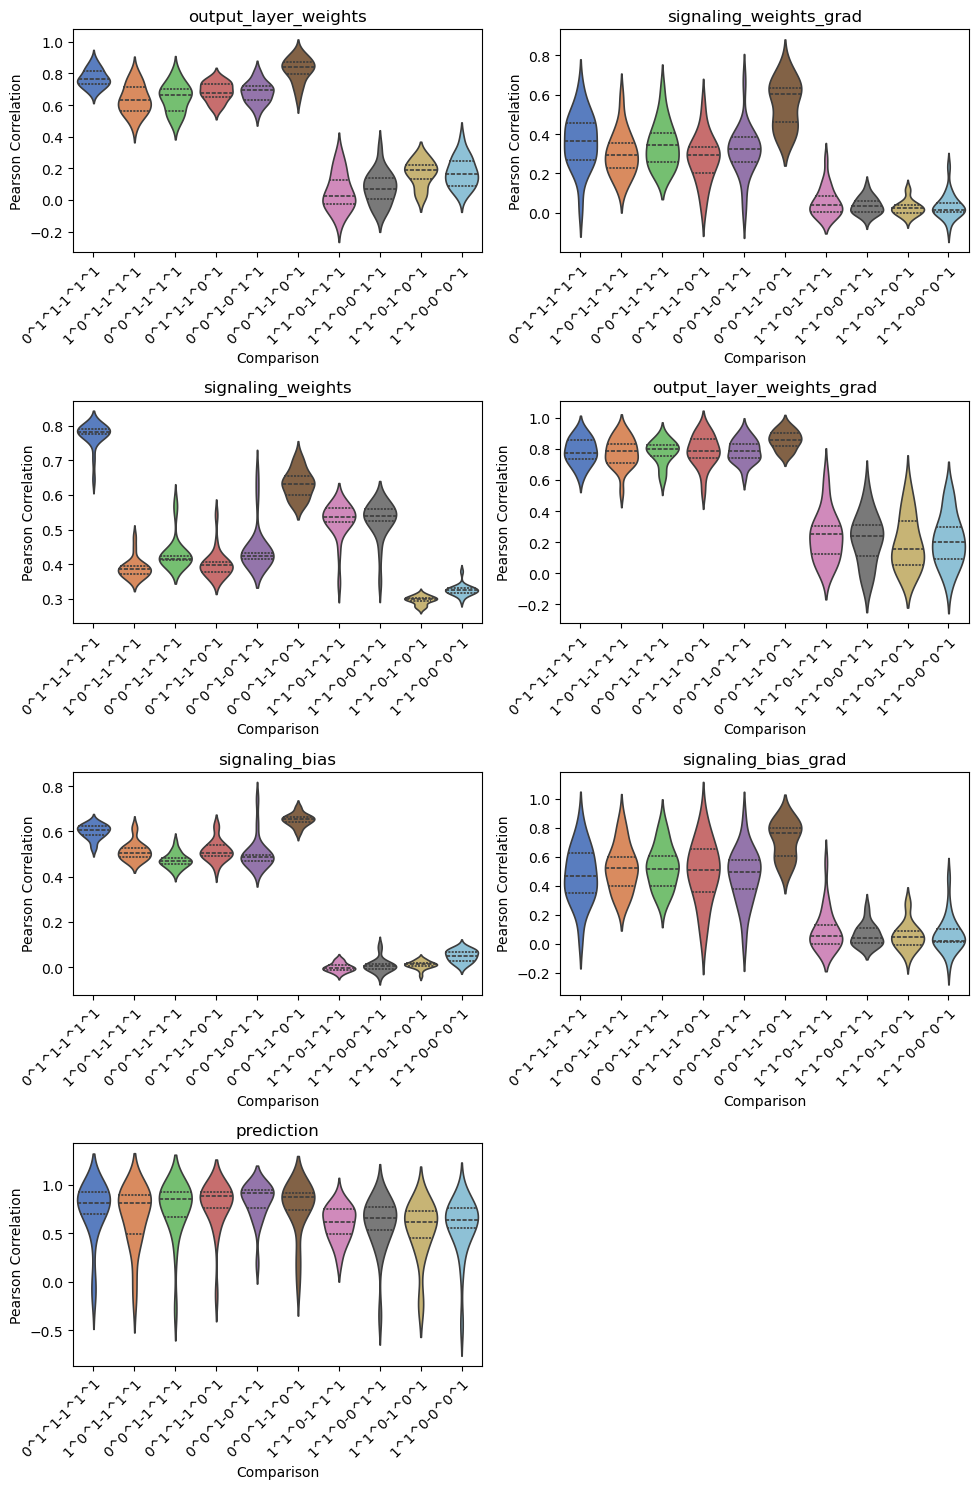

In [67]:
fig, ax = plt.subplots(ncols = 2, nrows = 4, figsize = (10, 15))
ax = ax.flatten()

for i, (viz_col, viz_df) in enumerate(viz_dfs.items()):
    sns.violinplot(data = viz_df, x = 'comparison', y = viz_col, ax = ax[i], 
                  palette='muted', inner='quartile', linewidth=1.2, zorder = 1)

    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
    ax[i].xaxis.set_tick_params(which='both', bottom=True, top=False, direction='out')
    ax[i].yaxis.set_tick_params(which='major', left=True, right=False, direction='out')
    ax[i].set_ylabel('Pearson Correlation')
    ax[i].set_xlabel('Comparison')
    ax[i].set_title(viz_col)
fig.tight_layout()
ax[7].axis("off")
;
